# Timeseries and level 2 data

This notebook shows how you can prepare custom timeseries for different locations or level 2 data for user data upload to QA4SM.

For both kind of data, we assume that you are able to read the data for each location as a `pandas.Series` object with a `pandas.DatetimeIndex` as index corresponding to the acquisition times of the data. In contrast to the "stack" format for level 3 user data upload, the timestamps can be different for each location.
If you have level 2 data as images of single orbits only, you either have to extract the timeseries, or you might be able to convert it to a stack. The latter option is described at the bottom of this notebook.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Timeseries data

Custom timeseries data can be uploaded to QA4SM in the [contiguous ragged timeseries format](http://cfconventions.org/Data/cf-conventions/cf-conventions-1.9/cf-conventions.html#_contiguous_ragged_array_representation). To create a netCDF file in this format, we provide some convenience functions in the `qa4sm_preprocessing` package.

For now, assume that we have 3 timeseries (e.g. from in-situ data) from 3 different locations, with strongly varying timestamps:

In [2]:
# timeseries 1: daily timestamps
index = pd.date_range("2020-01-01 12:00", "2020-12-31 12:00", freq="D")
data = np.random.randn(len(index))
ts1 = pd.Series(data, index=index)
lat1 = 12
lon1 = 0.1

# timeseries 2: hourly timestamps, but shorter period
index = pd.date_range("2020-06-01", "2020-08-01", freq="H")
data = np.random.randn(len(index)) + 2
ts2 = pd.Series(data, index=index)
lat2 = 34
lon2 = 2.3

# timeseries 3: irregular timestamps
index = pd.DatetimeIndex(np.datetime64("2020-01-01") + np.random.rand(1000) * np.timedelta64(365*24*60, "m"))
data = np.random.randn(len(index)) - 2
ts3 = pd.Series(data, index=index)
lat3 = 56
lon3 = 4.5

In [3]:
ts1

2020-01-01 12:00:00   -0.176359
2020-01-02 12:00:00    1.180896
2020-01-03 12:00:00    0.184335
2020-01-04 12:00:00    0.787736
2020-01-05 12:00:00   -0.935653
                         ...   
2020-12-27 12:00:00   -0.354969
2020-12-28 12:00:00   -1.349662
2020-12-29 12:00:00   -1.440345
2020-12-30 12:00:00    0.628193
2020-12-31 12:00:00   -0.820691
Freq: D, Length: 366, dtype: float64

In [4]:
ts2

2020-06-01 00:00:00    0.323871
2020-06-01 01:00:00    4.089820
2020-06-01 02:00:00    1.066759
2020-06-01 03:00:00    0.934358
2020-06-01 04:00:00    2.467316
                         ...   
2020-07-31 20:00:00    2.617557
2020-07-31 21:00:00    3.508354
2020-07-31 22:00:00    0.605593
2020-07-31 23:00:00    0.727697
2020-08-01 00:00:00    3.187725
Freq: H, Length: 1465, dtype: float64

In [5]:
ts3

2020-08-13 22:41:00   -3.307247
2020-05-23 23:30:00   -1.498388
2020-07-16 01:22:00   -1.866384
2020-06-11 19:58:00   -2.360786
2020-01-14 12:29:00   -0.321700
                         ...   
2020-02-05 20:02:00   -2.885371
2020-03-11 21:51:00   -3.441089
2020-12-09 13:18:00   -0.836830
2020-11-04 16:00:00    0.069317
2020-05-05 16:09:00   -0.797554
Length: 1000, dtype: float64

<AxesSubplot:>

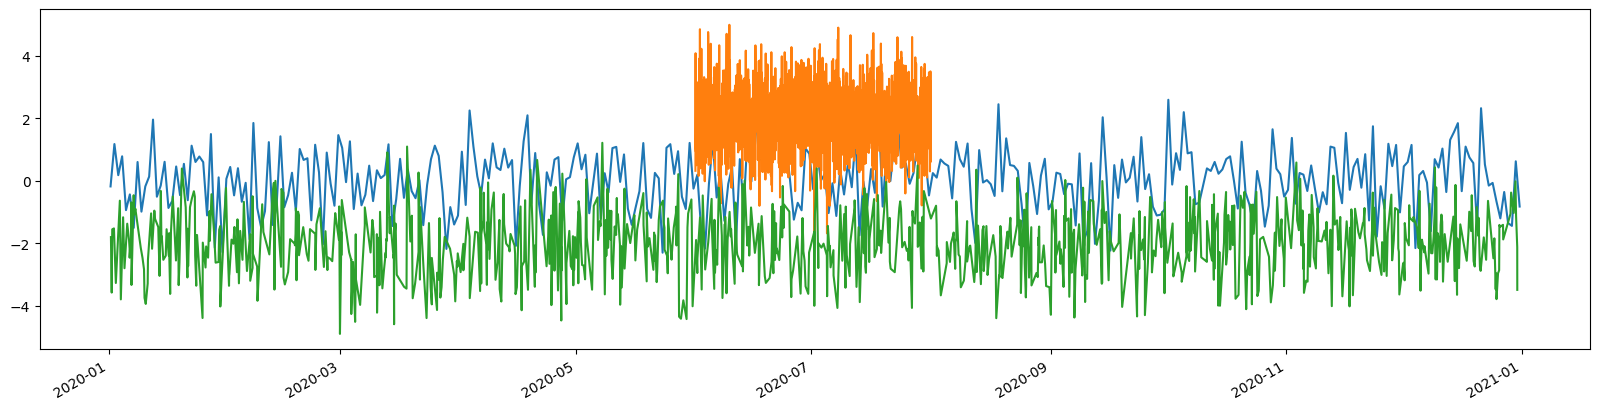

In [6]:
plt.figure(figsize=(20, 5))
ts1.plot()
ts2.plot()
ts3.plot()

We now have 3 timeseries, and the coordinates of them. This is all we need for creating the contiguous ragged format:

In [7]:
lats = [lat1, lat2, lat3]
lons = [lon1, lon2, lon3]
timeseries = [ts1, ts2, ts3]

from qa4sm_preprocessing.reading.timeseries import make_contiguous_ragged_array

cont_ragged_ts = make_contiguous_ragged_array(timeseries, lons, lats, name="soil_moisture")
cont_ragged_ts

<xarray.Dataset>
Dimensions:           (loc: 3, loctime: 2831)
Dimensions without coordinates: loc, loctime
Data variables:
    lon               (loc) float64 0.1 2.3 4.5
    lat               (loc) int64 12 34 56
    time              (loctime) datetime64[ns] 2020-01-01T12:00:00 ... 2020-0...
    soil_moisture     (loctime) float64 -0.1764 1.181 0.1843 ... 0.06932 -0.7976
    count             (loc) int64 366 1465 1000
    cumulative_count  (loc) int64 366 1831 2831

The result is a `xarray.Dataset` in a format that QA4SM can read. It can be stored as a netCDF file for uploading with `cont_ragged_ts.to_netcdf("my_ragged_ts.nc")`, but it can also just be used directly.

To make sure that it works the way it should, we can use the reader for the ragged timeseries arrays that is also used in QA4SM:

In [8]:
from qa4sm_preprocessing.reading.timeseries import ContiguousRaggedTs

ts = ContiguousRaggedTs(cont_ragged_ts)

This reader object has a `read` function, which takes as argument either a single integer grid point index (corresponding to the order that the timeseries where passed in the call to `make_contiguous_ragged_array`), or a longitude and latitude value, and returns a `pandas.DataFrame` with a single column (column name is the name supplied above):

<AxesSubplot:>

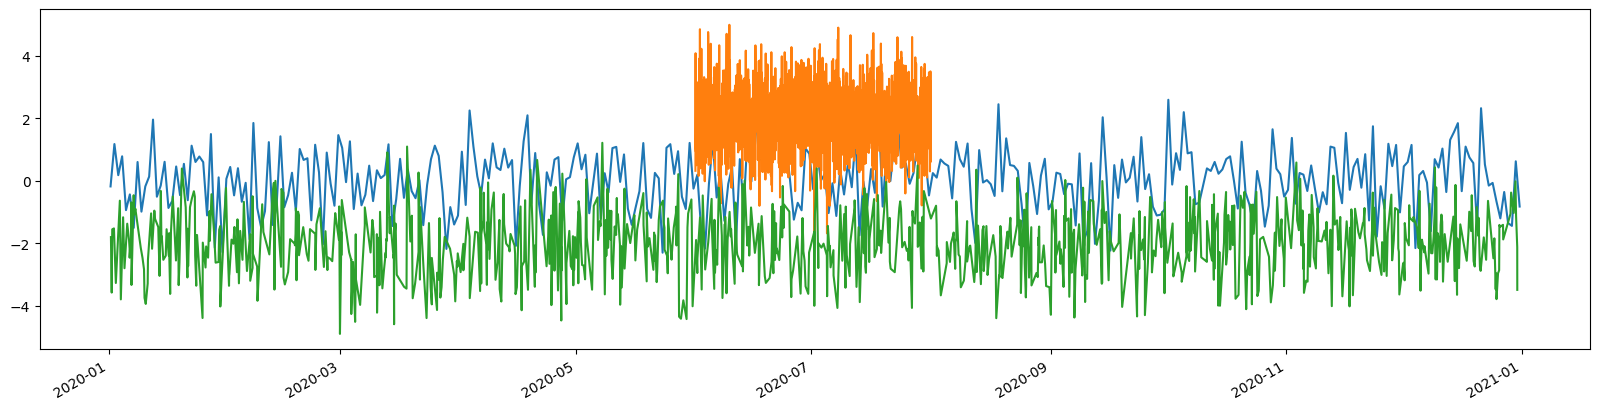

In [9]:
ts1_from_ragged = ts.read(0)  # 0-based indexing!
ts2_from_ragged = ts.read(2.3, 34)
ts3_from_ragged = ts.read(2)  # 0-based indexing

assert ts1_from_ragged["soil_moisture"].equals(ts1)
assert ts2_from_ragged["soil_moisture"].equals(ts2)
assert ts3_from_ragged["soil_moisture"].equals(ts3)

plt.figure(figsize=(20, 5))
ts1_from_ragged["soil_moisture"].plot()
ts2_from_ragged["soil_moisture"].plot()
ts3_from_ragged["soil_moisture"].plot()

## Alternative for level 2 data

If you have level 2 orbit files (i.e. single images, but not containing a complete global grid), it is also possible to create a stack file using the `qa4sm_preprocessing` package, but this requires some more effort.

This can be done by overriding the base level 2 reader class `qa4sm_preprocessing.level2.base.L2Reader`. In a subclass, you have to provide the following things:
- `_read_l2_file`: Should read a single orbit file and returns the data as dictionary of numpy array for each variable, as well as indices of the data in the global grid (array of grid point indices for unstructured grids, or row and column index if grid is 2-dimensional).
- `_time_regex_pattern`: Property that specifies how to extract the timestamp from the filename (and how to find files).
- `_gridinfo`: Returns a `qa4sm_preprocessing.reading.base.GridInfo` object for the global grid. For unstructured grids, this can be obtained via `GridInfo(lats, lons, "unstructured")`.
- `_variable_metadata`: Function that specifies the metadata for all the variables of interest, .e.g units, long name, validity bounds, etc.
- `_global_metadata`: Function that specifies metadata for the full dataset, e.g. name, references, version, etc. This is optional, but it is recommended to specify it.

For more info, you should probably have a look at the source code in `qa4sm_preprocessing/src/qa4sm_preprocessing/level2/base.py`. You can find two examples for SMOS and SMAP level 2 data in `qa4sm_preprocessing/src/qa4sm_preprocessing/level2/smos.py` and `qa4sm_preprocessing/src/qa4sm_preprocessing/level2/smap.py`, respectively. The former shows an example of how to read files from HDF5 files and with an unstructured global grid, the latter reads from netCDF files and has a curvilinear (2-dimensional) global grid.


Once you have your own subclass of `L2Reader`, you can simply do a call to the method `read_block(start, end)` (start and end optional), which returns the full data as a `xarray.Dataset` stack.